In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the random seed for reproducibility
np.random.seed(42)

# Define parameters for the damped harmonic oscillator
A = 1.0    # Amplitude
b = 0.05   # Damping coefficient
omega = 2 * np.pi / 5  # Angular frequency
T = 100    # Total time
dt = 0.1   # Time step

# Generate time points
t = np.arange(0, T, dt)

# Generate the damped oscillation data
x = A * np.exp(-b * t) * np.cos(omega * t)

# Add some noise to the data
noise = np.random.normal(scale=0.1, size=len(t))
x_noisy = x + noise

# Create a DataFrame
df = pd.DataFrame({'Time': t, 'Position': x_noisy})

df.to_excel('damped_oscillator.xlsx','series')

In [2]:
series = df['Position']

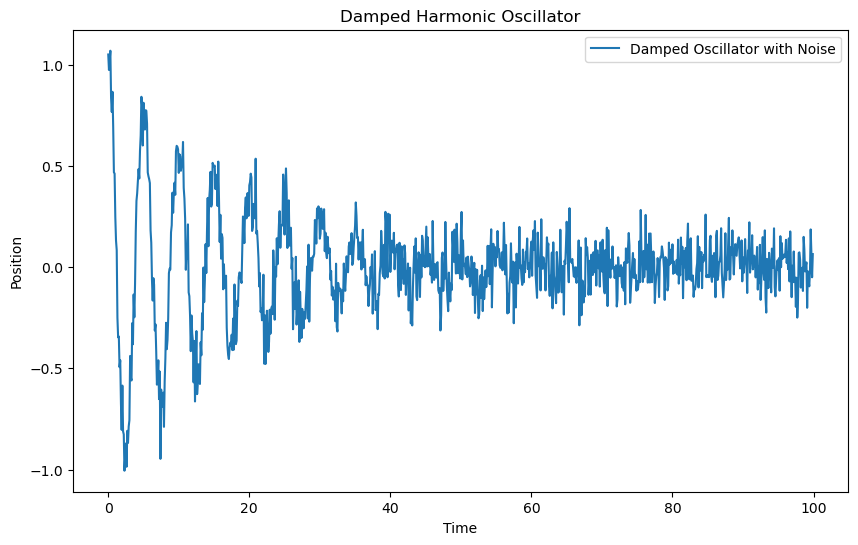

In [3]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Position'], label='Damped Oscillator with Noise')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator')
plt.legend()
plt.show()

In [4]:
# Define the SARIMAX model
#order = (2, 0, 2)  # (p, d, q) parameters for ARIMA
#seasonal_order = (1, 1, 1, 10)  # (P, D, Q, S) parameters for seasonal component

# find optimal parameters
import itertools

#Define the p, d and q parameters to take any value between 1 and 2
p = d = q = range(1, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets (i.e., P, D, Q)
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]

[(1, 1, 1), (1, 1, 2), (1, 2, 1), (1, 2, 2), (2, 1, 1), (2, 1, 2), (2, 2, 1), (2, 2, 2)] [(1, 1, 1, 10), (1, 1, 2, 10), (1, 2, 1, 10), (1, 2, 2, 10), (2, 1, 1, 10), (2, 1, 2, 10), (2, 2, 1, 10), (2, 2, 2, 10)]


In [ ]:
# Fit the model
#model = SARIMAX(df['Position'], order=pdq, seasonal_order=seasonal_pdq)
#results = model.fit()

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Indentification of best model from different combinations of pdq and seasonal_pdq
best_score, best_param, best_paramSeasonal = float("inf"), None, None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df['Position'], order=param, seasonal_order=param_seasonal, enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_score:
                best_score, best_param, best_paramSeasonal = results.aic, param, param_seasonal
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue # if fit fails, just continue to the next parameters combionation

ARIMA(1, 1, 1)x(1, 1, 1, 10) - AIC:-1248.8575678107377
ARIMA(1, 1, 1)x(1, 1, 2, 10) - AIC:-1255.3382808162773
ARIMA(1, 1, 1)x(1, 2, 1, 10) - AIC:-760.7443639150649
ARIMA(1, 1, 1)x(1, 2, 2, 10) - AIC:-1070.6323009836924
ARIMA(1, 1, 1)x(2, 1, 1, 10) - AIC:-1281.0707964031844
ARIMA(1, 1, 1)x(2, 1, 2, 10) - AIC:-1286.6872895760598


In [ ]:
# Print the best set of parameters according to the AIC.
print('The best model is ARIMA{}x{} - AIC:{}'.format(best_param, best_paramSeasonal, best_score))

In [ ]:
# Print the summary of the model
print(results.summary())

In [ ]:
# Forecast future values for 50 steps
n_forecast = 50  # Number of steps to forecast
forecast = results.get_forecast(steps=n_forecast)
forecast_index = np.arange(T, T + n_forecast * dt, dt)

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()


In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Position'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator with SARIMAX Forecast')
plt.legend()
plt.show()

In [ ]:
# Calculate SST, SSR, SSE, and R2
observed = df['Position']
mean_observed = np.mean(observed)
sst = np.sum((observed - mean_observed) ** 2)
sse = np.sum((observed - predictions) ** 2)
ssr = sst - sse
r2 = 1 - (sse / sst)

# Print the results
print(f'SST: {sst:.2f}')
print(f'SSE: {sse:.2f}')
print(f'SSR: {ssr:.2f}')
print(f'R²: {r2:.2f}')

# Plot the observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Position'], label='Observed', color='blue')
plt.plot(df['Time'], predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator: Observed vs Predicted')
plt.legend()
plt.show()

In [ ]:
# Compare computed R2 with that provided by statsmodel
print(results.rsquared, r2)

In [ ]:
# Calculate degrees of freedom
n = len(observed)  # Number of observations
p = 4  # Number of predictors in SARIMAX (p + d + q + seasonal components)

# Calculate MST, MSE, MSR, and F-score
mst = sst / (n - 1)
mse = sse / (n - p - 1)
msr = ssr / p
f_score = msr / mse

# Print the results
print(f'SST: {sst:.2f}')
print(f'SSE: {sse:.2f}')
print(f'SSR: {ssr:.2f}')
print(f'R²: {r2:.2f}')
print(f'MST: {mst:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MSR: {msr:.2f}')
print(f'F-score: {f_score:.2f}')